### KOZMOS - Amazon Yorumları için Duygu Analizi

**İş Problemi**

Amazon üzerinden satışlarını gerçekleştiren ev tekstili ve günlük giyim odaklı üretimler yapan **Kozmos**, ürünlerine gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını artırmayı hedeflemektedir. Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlenecek ve etiketlenen veri ile sınıflandırma modeli oluşturulacaktır.

**Veri Seti Hikayesi**

Veri seti belirli bir ürün grubuna ait yapılan yorumları, yorum başlığını, yıldız sayısını, ve yapılan yorumu kaç kişinin faydalı bulduğunu belirten değişkenlerden oluşmaktadır.

**Değişkenler**

**Star:** Ürüne verilen yıldız sayısı

**Helpful:** Yorumu faydalı bulan kişi sayısı

**Title:** Yorum içeriğine verilen başlık, kısa yorum

**Review:** Ürüne yapılan yorum

#### Görev 1: Metin Ön İşleme

**Adım 1:** amazon_kozmos_data.xlsx verisini okutunuz

In [1]:
# Gerekli kütüphane ve fonksiyonların kurulması

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# !pip install nltk
# !pip install textblob
# !pip install wordcloud

from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import Word, TextBlob
from wordcloud import WordCloud

pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_excel("datasets/amazon_kozmos_data.xlsx")

df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [2]:
df.shape

(5611, 4)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


**Adım 2:** Review değişkeni üzerinde ;

a. Tüm harfleri küçük harfe çeviriniz.

b. Noktalama işaretlerini çıkarınız.

c. Yorumlarda bulunan sayısal ifadeleri çıkarınız.

d. Bilgi içermeyen kelimeleri (stopwords) veriden çıkarınız.

e. 1000'den az geçen kelimeleri veriden çıkarınız.

f. Lemmatization işlemini uygulayınız.

In [4]:
df["Review"]

0                                           Happy with it
1       Good quality material however the panels are m...
2       Product was fun for bedroom windows.<br />Imag...
3        Lo unico que me gustaria es que sean un poco ...
4       Great bang for the buck I can't believe the qu...
                              ...                        
5606    Great product for reasonable money.  Delivered...
5607             Color is way off and panels do not match
5608    These are great for my studio as they compleme...
5609    Brought out the beauty in kids room. They love...
5610    Very cute curtains in my sons room! Thick enou...
Name: Review, Length: 5611, dtype: object

In [5]:
# Normalizing Case Folding

In [6]:
df["Review"] = df["Review"].str.lower()

df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

In [7]:
# Noktalama İşaretleri (Punctuations)

In [8]:
df["Review"] = df["Review"].str.replace("[^\w\s]", '')

df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [9]:
# Numbers

In [10]:
df["Review"] = df["Review"].str.replace("\d", "")

df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [11]:
# Stopwords

In [12]:
import nltk

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ogusan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
sw = stopwords.words("english")

sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [14]:
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

df["Review"]

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

In [15]:
# Rare Words / Custom Words

In [16]:
sil = pd.Series(' '.join(df["Review"]).split()).value_counts()[-1000:]

df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

df["Review"]

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme area phot...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

In [17]:
# Lemmatization

In [18]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ogusan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# df["Review"].head(10)

#### Görev 2: Metin Görselleştirme

**Adım 1:** Barplot görselleştirme işlemi için; 

a. "Review" değişkeninin içerdiği kelimelerin frekanslarını hesaplayınız, tf olarak kaydediniz.

b. tf dataframe'inin sütunlarını yeniden adlandırınız: "words", "tf" şeklinde

c. "tf" değişkeninin değeri 500'den çok olanlara göre filtreleme işlemi yaparak barplot ile görselleştirme işlemini tamamlayınız.

In [20]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()

tf

,index,0
0,happy,196.00
1,good,535.00
2,quality,889.00
3,material,561.00
4,however,78.00
...,...,...
5695,relatively,1.00
5696,crispbr,1.00
5697,wfh,1.00
5698,gamers,1.00


In [21]:
tf.columns = ["words", "tf"]

tf

,words,tf
0,happy,196.00
1,good,535.00
2,quality,889.00
3,material,561.00
4,however,78.00
...,...,...
5695,relatively,1.00
5696,crispbr,1.00
5697,wfh,1.00
5698,gamers,1.00


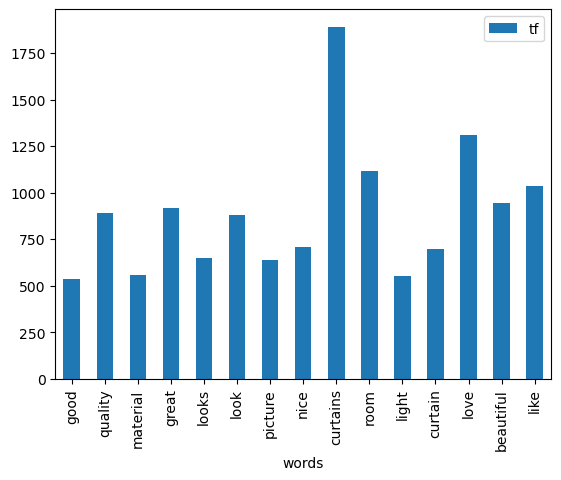

In [22]:
tf[tf["tf"] > 500].plot.bar(x = "words", y = "tf")

plt.show()

**Adım 2:** WordCloud görselleştirme işlemi için; 

a. "Review" değişkeninin içerdiği tüm kelimeleri "text" isminde string olarak kaydediniz.

b. WordCloud kullanarak şablon şeklinizi belirleyip kaydediniz.

c. Kaydettiğiniz wordcloud'u ilk adımda oluşturduğunuz string ile generate ediniz.

d. Görselleştirme adımlarını tamamlayınız. (figure, imshow, axis, show)

In [23]:
text = " ".join(i for i in df.Review)

text

'happy good quality material however panels mismatched product fun bedroom windowsbr imagery bit stretched still funbr material lightweight sheer appreciate lo unico que gustaria es que sean un poco mas largas great bang buck cant believe quality material vibrant colors eclectic style works beautifully ties together looks different photo exactly looking heavy material great price ships fast looking picture thought curtains would thinner sheer nice thickness weight help insulate front window look absolutely perfect arrived quickly pleased purchase much whiter thought would wasnt really expecting wanting use curtains picture shows rd set ambesonne curtains one set use spring summer one autumn set christmas winter durable colors vibrant recommend curtains blocks views living room front door kitchendining area dont stress dishes mess easily seen visitors put christmas lights around really brightens everything private closed darkening point dont block light work fine night curtains sheer da

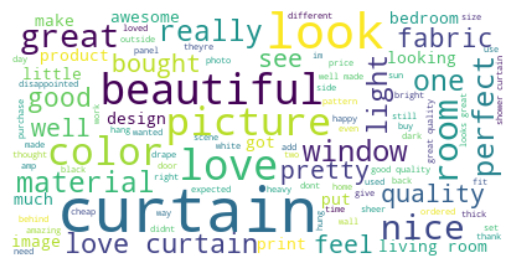

In [24]:
wordcloud = WordCloud(max_font_size = 50,
                      max_words = 100,
                      background_color = "white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

#### Görev 3: Duygu Analizi

**Adım 1:** Python içerisindeki NLTK paketinde tanımlanmış olan SentimentIntensityAnalyzer nesnesini oluşturunuz.

In [25]:
sia = SentimentIntensityAnalyzer()

**Adım 2:** SentimentIntensityAnalyzer nesnesi ile polarite puanlarını inceleyiniz;

a. "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplayınız.

b. İncelenen ilk 10 gözlem için compund skorlarına göre filtreleyerek tekrar gözlemleyiniz.

c. 10 gözlem için compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelleyiniz.

d. "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e
ekleyiniz.

In [26]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [27]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [28]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [29]:
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [30]:
df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg   3.39
pos   4.59
Name: Star, dtype: float64

In [31]:
#  NOT:SentimentIntensityAnalyzer ile yorumları etiketleyerek, yorum sınıflandırma makine öğrenmesi modeli için bağımlı değişken oluşturulmuş oldu.

#### Görev 4: Makine Öğrenmesine Hazırlık

**Adım 1:** Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olarak ayırınız.

In [32]:
# Test-Train

train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state = 42)

**Adım 2:** Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte;

a. TfidfVectorizer kullanarak bir nesne oluşturunuz.

b. Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz.

c. Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz.

In [33]:
# TF-IDF Word Level

tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

#### Görev 5: Modelleme (Lojistik Regresyon)

**Adım 1:** Lojistik regresyon modelini kurarak train dataları ile fit ediniz.

In [34]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

**Adım 2:** Kurmuş olduğunuz model ile tahmin işlemleri gerçekleştiriniz;

a. Predict fonksiyonu ile test datasını tahmin ederek kaydediniz.

b. classification_report ile tahmin sonuçlarınızı raporlayıp gözlemleyiniz.

c. cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.

In [35]:
y_pred = log_model.predict(x_test_tf_idf_word)

In [36]:
print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         neg       0.31      0.91      0.47        77
         pos       0.99      0.88      0.94      1326

    accuracy                           0.89      1403
   macro avg       0.65      0.90      0.70      1403
weighted avg       0.96      0.89      0.91      1403



In [37]:
cross_val_score(log_model, x_test_tf_idf_word, test_y, cv = 5).mean()

0.8531774275546518

**Adım 3:** Veride bulunan yorumlardan ratgele seçerek modele sorulması;

a. sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçerek yeni bir değere atayınız.

b. Elde ettiğiniz örneklemi modelin tahmin edebilmesi için CountVectorizer ile vektörleştiriniz.

c. Vektörleştirdiğiniz örneklemi fit ve transform işlemlerini yaparak kaydediniz.

d. Kurmuş olduğunuz modele örneklemi vererek tahmin sonucunu kaydediniz.

e. Örneklemi ve tahmin sonucunu ekrana yazdırınız.

In [38]:
random_review = pd.Series(df["Review"].sample(1).values)

In [39]:
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)

In [40]:
pred = log_model.predict(yeni_yorum)

In [41]:
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  goes perfect love 
 Prediction: ['pos']


#### Görev 6: Modelleme (Random Forest)

**Adım 1:** Random Forest modeli ile tahmin sonuçlarının gözlenmesi;

a. RandomForestClassifier modelini kurup fit ediniz.

b. Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.

c. Lojistik regresyon modeli ile sonuçları karşılaştırınız.


In [42]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)

In [43]:
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv = 5, n_jobs = -1).mean()

0.8966548042704627

Random Forest Classifier algoritmasının başarısı, lojistik regresyondan bir tık yüksektir. 